In [1]:
#https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch-12a48cd1e573
import torch
import numpy as np
import os
import sys
sys.path.append('../')
os.environ["CUDA_VISIBLE_DEVICES"]="7"
import torchvision
from voc import *
from coco import *
import torchvision.transforms as transforms
# from torchvision.models import resnet152, resnet101, resnet18, resnet34, resnet50
from tqdm import tqdm
import json
import pandas as pd
import matplotlib.pyplot as plt
from config import seed_everything
seed_everything(0)
from models import *
from torchsummary import summary

import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms, utils
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
from PIL import Image
import json

from pytorch_grad_cam import GradCAM
%matplotlib inline

/home/seongha/anaconda3/envs/MGSSL/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from backbones.config import config

In [3]:
from models import *
from backbones.config import config
import pathlib

print(config)

{'resnet50': 'resnetv2_50x3_bitm_in21k', 'swin': 'swin_base_patch4_window12_384_in22k', 'swin_large': 'swin_large_patch4_window12_384_in22k', 'convnext': 'convnext_large_in22k', 'resnet101': 'resnetv2_101x3_bitm_in21k'}


In [62]:
path ='checkpoint/coco/coco_squeeze-excitation-noscale_resnet101_base_best.pth.tar'
di = torch.load("../{}".format(path))
image_size=224
model = base_resnet101(config['resnet101'], 80, image_size)
# model = base_swin(config['swin_large'], 80, 384,)
model.load_state_dict(di['state_dict'])
for n, p in model.named_parameters():
  if p.requires_grad==False:
    p.requires_grad=True


torch.Size([1, 768, 56, 56])
1 6144 1 1


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [51]:
import json
with open('../data/coco/data/category.json', 'r') as f:
  category = json.load(f)
  # category["banana"]
  inverse = {v:k for k, v in category.items()}

inverse[3]

'banana'

Get intersection between after-high score & before-low score

In [87]:
import pandas as pd
before = set(pd.unique(pd.read_csv('../figures/resnet101/topandworst_before.csv')[["-1", "-2", "-3"]].values.ravel('K')))
after = set(pd.unique(pd.read_csv('../figures/resnet101/topandworst.csv')[["1", "2", "3"]].values.ravel('K')))

after.intersection(before)


{'COCO_val2014_000000159240.jpg', 'COCO_val2014_000000305978.jpg'}

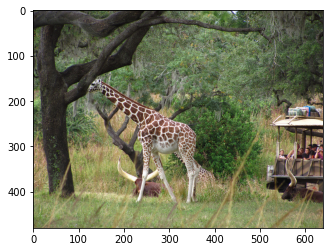

In [91]:
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
import cv2
#COCO_val2014_000000154095.jpg	COCO_val2014_000000532919.jpg	COCO_val2014_000000178671.jpg
hard_img_id = '/home/seongha/LT-ML/data/coco/data/val2014/{}'.format("COCO_val2014_000000154095.jpg") #banana
object = 'banana'

hard_img_id = '/home/seongha/LT-ML/data/coco/data/val2014/{}'.format("COCO_val2014_000000159240.jpg")
object= inverse[69]


hard_img_id = '/home/seongha/LT-ML/data/coco/data/val2014/{}'.format("COCO_val2014_000000305978.jpg")
object= inverse[64]


image = np.array(Image.open(hard_img_id))
plt.imshow(image)
import copy

image = cv2.resize(image, (image_size, image_size))
image = np.float32(image) / 255
# image = transform(image)
original_img = copy.copy(image)
image = preprocess_image(image,
                        mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
image = image.to(device)
x = torch.clone(image)

# print(x)

In [16]:

def reshape_transform(tensor, height=12, width=12):
    h = int(math.sqrt(tensor.size(1)))
    # print(tensor.size(0), tensor.size(1), tensor.size(2), tensor.size(4))
    result = tensor.reshape(tensor.size(0),
        h, h, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [92]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad, LayerCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

#swin large @ 0
# target_layers = [ model.inter[2].blocks[1].norm1,model.features[0].blocks[1].norm1, model.features[1].blocks[1].norm1, model.features[2].blocks[1].norm1 ]
target_layers = [model.intermediate[-1].blocks[-1].norm1, model.features[0].blocks[-1].norm1, model.features[1].blocks[-1].norm1, model.features[2].blocks[-1].norm1]
for i in range(len(target_layers)):
  input_tensor = image
  # Create an input tensor image for your model..
  # Note: input_tensor can be a batch tensor with several images!

  # Construct the CAM object once, and then re-use it on many images:
  # cam = GradCAMPlusPlus(model=model, target_layers=[target_layers[i]], use_cuda=torch.cuda.is_available(), reshape_transform=reshape_transform)
  cam = EigenCAM(model=model, target_layers=[target_layers[i]], use_cuda=torch.cuda.is_available())

  # You can also use it within a with statement, to make sure it is freed,
  # In case you need to re-create it inside an outer loop:
  # with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
  #   ...

  # We have to specify the target we want to generate
  # the Class Activation Maps for.
  # If targets is None, the highest scoring category
  # will be used for every image in the batch.
  # Here we use ClassifierOutputTarget, but you can define your own custom targets
  # That are, for example, combinations of categories, or specific outputs in a non standard model.

  targets = [ClassifierOutputTarget(64)]

  # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
  grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]
  visualization = show_cam_on_image(original_img, grayscale_cam, use_rgb=True)
  Image.fromarray(visualization).save("../figures/resnet101/eigencam/EigenCAM_{}_at{}.pdf".format(object, i+1))